In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
df = pd.read_csv('../data/dataset/News_Yahoo_stock.csv', index_col=0)

# check for nan values
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15975 entries, 0 to 15974
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    15975 non-null  object
 1   content  15975 non-null  object
 2   label    15975 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 499.2+ KB


Awesome! There is no NaN values in dataset

In [12]:
# drop duplicates if content is the same
n_before = len(df)
df.drop_duplicates(subset=['content'], inplace=True)
n_after = len(df)
print(f"Dropped {n_before - n_after} duplicate rows")

Dropped 17 duplicate rows


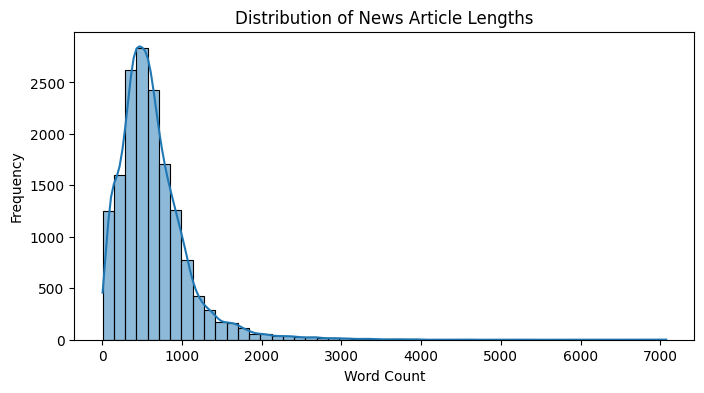

In [13]:
df['content_length'] = df['content'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 4))
sns.histplot(df['content_length'], bins=50, kde=True)
plt.title('Distribution of News Article Lengths')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

In [14]:
print("Article length statistics (in words):")
print(f"Median: {df['content_length'].median():.0f}")
print(f"Mean: {df['content_length'].mean():.0f}") 
print(f"5th percentile: {df['content_length'].quantile(0.05):.0f}")
print(f"25th percentile: {df['content_length'].quantile(0.25):.0f}")
print(f"75th percentile: {df['content_length'].quantile(0.75):.0f}")
print(f"95th percentile: {df['content_length'].quantile(0.95):.0f}")

Article length statistics (in words):
Median: 555
Mean: 634
5th percentile: 112
25th percentile: 364
75th percentile: 809
95th percentile: 1402


The histogram shows a distribution typical for news articles with a 'right tail':

There's a small number of extremely short texts (<100 words) and a noticeable quantity of 'very heavy' articles exceeding 2,000–3,000 words, with some reaching up to 7,000 words.

For data preparation, we'll exclude extremes:

Trim excessively short 'joke' notes (<100 words) - they're poorly suited for summarization.
Discard overly long articles (>2,000 words) to stay within tokenizer's max_length limits.
For fine-tuning, we'll use the bulk of the sample within the 5th-95th percentiles:

lower = 112 words
upper = 1,402 words

This covers 90% of all articles while maintaining:
'Short' (200-400 words)
'Medium' (400-900 words)
'Long' (900-1,200 words)
... without extreme tails.

Dataset boundaries:
5th percentile: 112 words
95th percentile: 1402 words

Original dataset size: 15,958 articles
Filtered dataset size: 14,366 articles
Percentage of articles retained: 90.0%


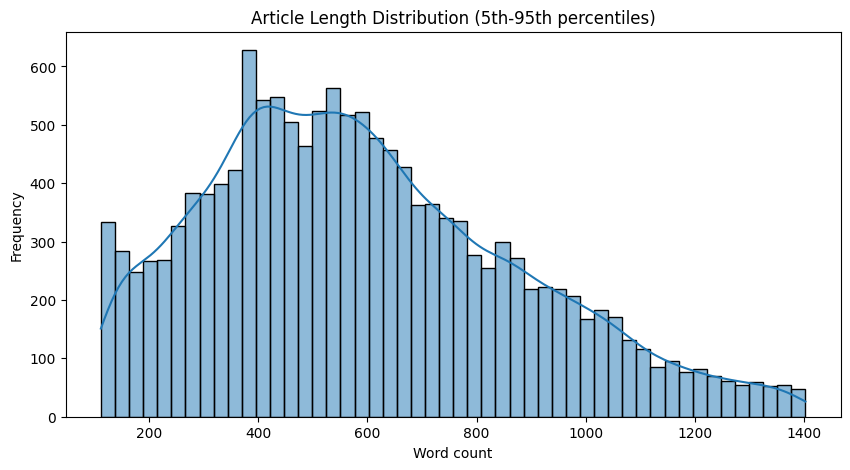

In [15]:
# Define 5th and 95th percentile boundaries
lower_bound = df['content_length'].quantile(0.05)
upper_bound = df['content_length'].quantile(0.95)

# Filter dataset using these boundaries
df_filtered_percentiles = df[(df['content_length'] >= lower_bound) & 
                           (df['content_length'] <= upper_bound)].copy()

print(f"Dataset boundaries:")
print(f"5th percentile: {lower_bound:.0f} words")
print(f"95th percentile: {upper_bound:.0f} words")
print(f"\nOriginal dataset size: {len(df):,} articles")
print(f"Filtered dataset size: {len(df_filtered_percentiles):,} articles")
print(f"Percentage of articles retained: {len(df_filtered_percentiles)/len(df)*100:.1f}%")

# Visualize the filtered distribution
plt.figure(figsize=(10, 5))
sns.histplot(data=df_filtered_percentiles, x='content_length', bins=50, kde=True)
plt.title('Article Length Distribution (5th-95th percentiles)')
plt.xlabel('Word count')
plt.ylabel('Frequency')
plt.show()

**Stratified Sampling**
To ensure the model performs well across different lengths, we'll bucket texts into bins:

- 200–400 words
- 400–700 words
- 700–1,000 words
- 1,000–1,200 words
- 1,200–1,400 words

We'll then randomly sample approximately equal quantities from each bin.

Article count per bin:
length_bin
400-700      5729
200-400      4054
700-1000     3153
1000-1200     969
1200-1400     456
Name: count, dtype: int64


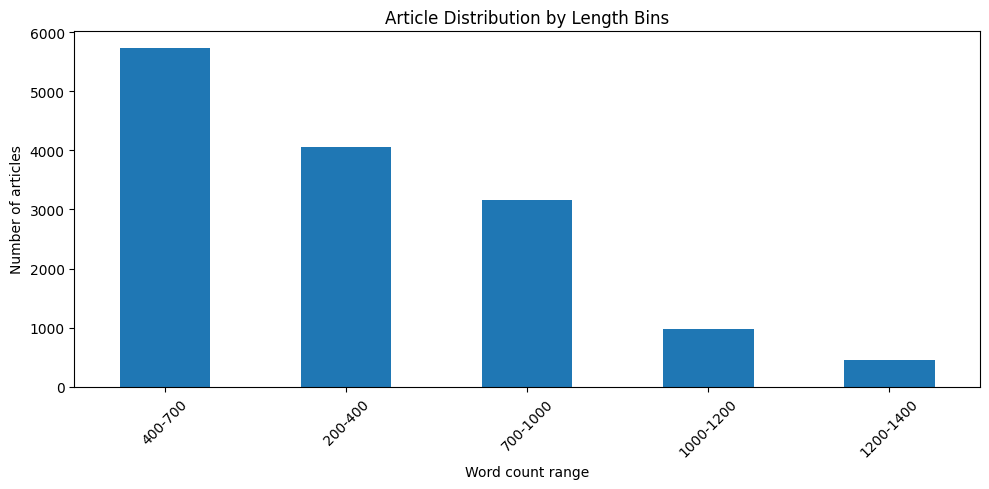

In [16]:
# Define bin boundaries
bins = [0, 400, 700, 1000, 1200, 1400]
labels = ['200-400', '400-700', '700-1000', '1000-1200', '1200-1400']

# Create bin column
df_filtered_percentiles['length_bin'] = pd.cut(df_filtered_percentiles['content_length'], 
                                             bins=bins, 
                                             labels=labels,
                                             include_lowest=True)

# Calculate article counts per bin
bin_counts = df_filtered_percentiles['length_bin'].value_counts()
print("Article count per bin:")
print(bin_counts)

# Visualize bin distribution
plt.figure(figsize=(10, 5))
bin_counts.plot(kind='bar')
plt.title('Article Distribution by Length Bins')
plt.xlabel('Word count range')
plt.ylabel('Number of articles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
df_filtered_percentiles['content']

0        Technology giant Apple   NASDAQ AAPL   is set ...
2        S P 500  SPY \nThis week will be packed with e...
3          Reports Q1 2020 results on Tuesday  Jan  28 ...
4        On today s episode of Full Court Finance here ...
5        Monday  January 27  2020The Zacks Research Dai...
                               ...                        
15968    Apple s  AAPL  sales for the third quarter mis...
15971    Here is a current sheet of companies with fast...
15972    Europe flares as summer heat continues  Summer...
15973    Last quarter Apple  AAPL  reported the 2nd bes...
15974    It may look like a spider web  but the mishmas...
Name: content, Length: 14366, dtype: object

In [18]:
# Create final dataset
# Take 50 samples from each bin
samples = []
for bin_label in labels:
    bin_sample = df_filtered_percentiles[df_filtered_percentiles['length_bin'] == bin_label].sample(n=50, random_state=42)
    samples.append(bin_sample['content'].values)

# Combine all samples into one dataset
dataset = pd.DataFrame({
    'article': [article for sample in samples for article in sample]
})

# Save to CSV
dataset.to_csv('dataset.csv', index=False)

# Display first few rows for verification
dataset

,article
0,Investing com Apple led tech lower Friday af...
1,As of late it has definitely been a great tim...
2,SCANA Corporation s NYSE SCG first quarter ...
3,New York based Intercept Pharmaceuticals Inc ...
4,Investing com Stocks in focus in pre market ...
...,...
245,For Immediate ReleaseChicago IL June 10 201...
246,For Immediate ReleaseChicago IL June 25 201...
247,It s report card time \nRoughly 1 100 companie...
248,For Immediate Release \n\nChicago IL May 02...


In [19]:
# View the longest articles in the sample (over 1400 words)
long_articles = df_filtered_percentiles[df_filtered_percentiles['content_length'] > 1400]
long_articles

,title,content,label,content_length,length_bin
94,Technically Speaking Extreme Deviations Eve...,The good news is that with the market closed y...,0,1401,NaN
1327,The Zacks Analyst Blog Highlights Molina NRG...,For Immediate ReleaseChicago IL September 10...,0,1402,NaN
3960,Bumper Jobs Report Dovish Fed Comments Help B...,Monday Market Open In recent days when the ...,0,1401,NaN
5042,October Doesn t Disappoint Volatility Is Back...,According to the 2018 edition of the Stock Tra...,0,1402,NaN
10569,Zacks Industry Outlook Highlights United Cont...,For Immediate Release\n\n\tChicago IL June ...,0,1401,NaN


Token count statistics for the longest articles (>1400 words):

Mean token count: 1,808
95th percentile: 1,858
Maximum token count: 1,860

This suggests that 2,048 tokens should be sufficient to process most market news articles.
For training, we'll tokenize with max_length≈4,096 tokens (with buffer) - this will cover nearly all texts without significant truncation.

In [20]:
# Calculation method:

# import pandas as pd
# import numpy as np
# long_articles = pd.read_csv('/app/scripts/long_articles.csv')

# token_counts = []
# for text in long_articles['content']:
#     token_count = llm.count_tokens(text)
#     token_counts.append(token_count)

# # Calculate statistics
# mean_tokens = np.mean(token_counts)
# p95_tokens = np.percentile(token_counts, 95)
# max_tokens = np.max(token_counts)

# print(f"Token count statistics for long articles (>1400 words):")
# print(f"Mean token count: {mean_tokens:.0f}")
# print(f"95th percentile: {p95_tokens:.0f}")
# print(f"Maximum token count: {max_tokens:.0f}")

In [21]:
gpt_answers = pd.read_csv('/Users/danildorofeev/Desktop/financial-news-summarizer/data/dataset/zero_shot_dataset_by_gpt.csv')
qwen_answers_zero = pd.read_csv('/Users/danildorofeev/Desktop/financial-news-summarizer/data/dataset/zero_shot_dataset_by_qwen.csv')
qwen_answers_few_shot = pd.read_csv('/Users/danildorofeev/Desktop/financial-news-summarizer/data/dataset/few_shot_dataset_by_qwen.csv')

In [24]:
# Merge dataframes by the 'article' column
# Rename prediction column in qwen_answers_zero to prediction_zero_shot
qwen_answers_zero = qwen_answers_zero.rename(columns={'prediction': 'prediction_zero_shot'})
# Rename prediction column in qwen_answers_few_shot to prediction_few_shot 
qwen_answers_few_shot = qwen_answers_few_shot.rename(columns={'prediction': 'prediction_few_shot'})

merged_df = pd.merge(gpt_answers, qwen_answers_zero, on='article')
merged_df = pd.merge(merged_df, qwen_answers_few_shot, on='article')
merged_df.head()


,article,ground_truth,prediction_zero_shot,prediction_few_shot
0,Investing com Apple led tech lower Friday af...,Headline: Morgan Stanley Cuts Apple Price Targ...,<think>\n\n</think>\n\nHeadline: Apple Shares ...,<think>\n\n</think>\n\nHeadline: Apple Price C...
1,As of late it has definitely been a great tim...,Headline: Deciphera Pharmaceuticals Stock Show...,<think>\n\n</think>\n\nHeadline: Deciphera Pha...,<think>\n\n</think>\n\nHeadline: Deciphera Pha...
2,SCANA Corporation s NYSE SCG first quarter ...,Headline: SCANA Q1 Earnings Miss Estimates Ami...,<think>\n\n</think>\n\nHeadline: SCANA Earning...,<think>\n\n</think>\n\nHeadline: SCANA Reports...
3,New York based Intercept Pharmaceuticals Inc ...,Headline: Intercept Pharmaceuticals Reports Ea...,<think>\n\n</think>\n\nHeadline: Intercept Pha...,<think>\n\n</think>\n\nHeadline: Intercept Pha...
4,Investing com Stocks in focus in pre market ...,Headline: Pre-Market Stock Movements: Boeing U...,<think>\n\n</think>\n\nHeadline: Stocks Rise a...,<think>\n\n</think>\n\nHeadline: Stocks in Foc...


In [25]:
merged_df.to_csv('ready_dataset.csv', index=False)